# Creating the Gene Table
This notebook is copied from the [Pymodulon GitHub repository](https://github.com/SBRG/pymodulon/blob/master/docs/tutorials/creating_the_gene_table.ipynb)

In [2]:
from pymodulon.gene_util import *
import os
import pandas as pd

## Get information from GFF files

First, download the FASTA and GFF files for your organism and its plasmids from NCBI.

Enter the location of all your GFF files here:

In [3]:
gff_files = [os.path.join('../..','data','external','genome.gff')]

The following cell will convert all the GFF files into a single Pandas DataFrame for easy manipulation. Pseudogenes have multiple rows in a GFF file (one for each fragment), but only the first fragment will be kept.

In [4]:
keep_cols = ['accession','start','end','strand','gene_name','old_locus_tag','gene_product','ncbi_protein']

DF_annot = gff2pandas(gff_files,index='locus_tag')
DF_annot = DF_annot[keep_cols]

DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,
XNR_RS30570,NC_020990.1,536.0,1609.0,-,None,XNR_0001,hypothetical protein,WP_015506672.1
XNR_RS00005,NC_020990.1,1681.0,1908.0,-,None,None,hypothetical protein,WP_041826573.1
XNR_RS00010,NC_020990.1,3324.0,3533.0,-,None,None,hypothetical protein,WP_041826574.1
XNR_RS00015,NC_020990.1,3671.0,4441.0,-,None,XNR_0003,IS5-like element IS112 family transposase,WP_003949000.1
XNR_RS00020,NC_020990.1,4485.0,5069.0,-,None,XNR_0004,hypothetical protein,WP_003946441.1


To ensure that the gene index used is identical to the expression matrix, load in your data.

In [5]:
log_tpm_file = os.path.join('../..','data','processed','log_tpm.csv')
DF_log_tpm = pd.read_csv(log_tpm_file,index_col=0)
DF_log_tpm.head()

,138-Dcellobiose,140-Dcellobiose,149-LAlanine,150-LAlanine,155-Glucose,156-Glucose,159-Xylose,160-Xylose,165-ISP22,167-ISP22,...,SRX10298361,SRX10298362,SRX10298363,SRX10298364,SRX10298365,SRX10298366,SRX10298367,SRX10298368,SRX10298369,SRX10298370
Geneid,,,,,,,,,,,,,,,,,,,,,
XNR_RS30570,5.273563,5.247552,6.956123,6.619123,6.915530,7.009776,6.625254,6.570320,4.124383,5.588035,...,6.132781,6.621700,6.903440,6.604174,6.691678,7.164275,7.017172,7.072368,6.938459,6.351649
XNR_RS00005,5.707565,6.120847,7.970440,7.316582,8.335740,8.400185,7.474105,7.718949,6.193782,6.072599,...,8.366081,7.511306,7.104326,6.820059,8.440797,7.721760,7.318962,7.476157,6.712702,7.017511
XNR_RS00010,2.426080,2.287586,3.818268,4.241475,4.141733,4.401422,3.860521,3.567841,3.410670,3.379892,...,2.957994,4.761928,2.494315,0.000000,2.286336,3.434424,0.000000,2.631187,1.495302,0.000000
XNR_RS00015,7.252156,7.308897,7.402119,7.404085,7.604939,7.565636,7.273547,7.362096,7.314383,7.269302,...,7.520143,7.329790,7.383690,7.468229,7.248420,7.518700,7.267862,7.317310,7.502759,7.015901
XNR_RS00020,6.261563,6.332104,6.779826,6.447123,6.703674,6.999367,6.695554,6.672637,7.387846,7.143159,...,7.479133,7.624058,7.084916,7.537412,7.073041,6.883898,7.204238,6.911212,6.747500,6.612837


Check that the genes are the same in the expression dataset as in the annotation dataframe. Mismatched genes are listed below.

In [6]:
test = DF_annot.sort_index().index == DF_log_tpm.sort_index().index
DF_annot[~test]

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,


## (Optional) KEGG and COGs

### Generate nucleotide fasta files for CDS

Enter the location of all your fasta files here:

In [7]:
fasta_files = [os.path.join('../..','data','external','genome.fasta')]

The following code generates CDS files using your FASTA and GFF3 files

In [8]:
from Bio import SeqIO

cds_list = []
for fasta in fasta_files:
    seq = SeqIO.read(fasta, 'fasta')

    # Get gene information for genes in this fasta file
    df_genes = DF_annot[DF_annot.accession == seq.id]

    for i, row in df_genes.iterrows():
        start = int(row.start) - 1  # Convert to integer
        end = int(row.end)  # Convert to integer
        cds = seq[start:end]
        if row.strand == '-':
            cds = seq[start:end].reverse_complement()
        cds.id = row.name
        cds.description = row.gene_name if pd.notnull(row.gene_name) else row.name
        cds_list.append(cds)


In [9]:
cds_list[:5]

[SeqRecord(seq=Seq('ATGGCCCGCCCCATGAACCGCCTGCCGCAAAGCAATGAGCCGCTCGTAGCCTTC...TAG'), id='XNR_RS30570', name='<unknown name>', description='XNR_RS30570', dbxrefs=[]),
 SeqRecord(seq=Seq('TTGTCGTACCTGCTTCCTGAGCCCGCCCCGGCCAACCAGGGCGGGCCGTGCGCG...TAA'), id='XNR_RS00005', name='<unknown name>', description='XNR_RS00005', dbxrefs=[]),
 SeqRecord(seq=Seq('GTGGACCTGCTCCAGGCCATCGGCGGAGAGAAGCCCGCGTACCTGCTCACCGGG...TGA'), id='XNR_RS00010', name='<unknown name>', description='XNR_RS00010', dbxrefs=[]),
 SeqRecord(seq=Seq('GTGGCTGGTGTGATCACTGCGTCGGAGCCGTCCTGGATTGCCCCGTTCAGCGGG...TAA'), id='XNR_RS00015', name='<unknown name>', description='XNR_RS00015', dbxrefs=[]),
 SeqRecord(seq=Seq('GTGAGCGGCGCAAGCGACCTGTGGGGAGAATTCGGCAAACACCACGCACAAGGC...TAA'), id='XNR_RS00020', name='<unknown name>', description='XNR_RS00020', dbxrefs=[])]

Save the CDS file

In [10]:
cds_file = os.path.join('../..','data','external','CDS.fna')
SeqIO.write(cds_list, cds_file, 'fasta')

5886

### Run EggNOG Mapper
1. Go to http://eggnog-mapper.embl.de/.
1. Upload the CDS.fna file from your organism directory (within the sequence_files folder)
1. Make sure to limit the taxonomy to the correct level
1. After the job is submitted, you must follow the link in your email to run the job.
1. Once the job completes (after ~4 hrs), download the annotations file.
1. Save the annotation file

### Get KEGG IDs

Once you have the EggNOG annotations, load the annotation file

In [11]:
eggnog_file = os.path.join('../..','data','external','eggNOG_annotations.csv')

In [12]:
DF_eggnog = pd.read_csv(eggnog_file,skiprows=4, header='infer')
eggnog_cols = ['query','seed_ortholog','evalue','score',
               'eggNOG_OGs','max_annot_lvl','COG_category',
               'Description','Preferred_name','GOs','EC','KEGG_ko',
               'KEGG_Pathway','KEGG_Module','KEGG_Reaction','KEGG_rclass','BRITE','KEGG_TC',
               'CAZy','BiGG_Reaction','PFAMs']

DF_eggnog.columns = eggnog_cols

# Strip last three rows as they are comments
DF_eggnog = DF_eggnog.iloc[:-3]

# Set locus tag as index
DF_eggnog = DF_eggnog.set_index('query')
DF_eggnog.index.name = 'locus_tag'

DF_eggnog.head()

,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,EC,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
locus_tag,,,,,,,,,,,,,,,,,,,,
XNR_RS30570,457425.XNR_0001,5.500000e-263,719.0,"COG1672@1|root,COG1672@2|Bacteria",2|Bacteria,-,-,-,-,-,-,-,-,-,-,-,-,-,-,"AAA_22,TIR_2,TniB"
XNR_RS00010,1463820.JOGW01000033_gene6587,1.220000e-12,67.8,"COG3935@1|root,COG3935@2|Bacteria,2IDRB@201174...",201174|Actinobacteria,L,DnaD domain protein,-,-,-,-,-,-,-,-,-,-,-,-,-
XNR_RS00015,457425.XNR_0003,4.870000e-188,521.0,"28PSB@1|root,2ZCDV@2|Bacteria,2GNDZ@201174|Act...",201174|Actinobacteria,S,DDE superfamily endonuclease,-,-,-,-,-,-,-,-,-,-,-,-,"DDE_Tnp_1,DDE_Tnp_4,HTH_Tnp_4"
XNR_RS00020,457425.XNR_0004,3.760000e-134,380.0,"2AKX1@1|root,31BQI@2|Bacteria,2GNMY@201174|Act...",201174|Actinobacteria,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
XNR_RS00025,457425.XNR_0005,4.180000e-214,591.0,"COG2944@1|root,COG2944@2|Bacteria,2GM0F@201174...",201174|Actinobacteria,K,sequence-specific DNA binding,-,-,-,-,-,-,-,-,-,-,-,-,"DnaB_C,HTH_3,HTH_31"


Now we will pull the KEGG information from the eggNOG file, including orthology, pathway, module, and reactions for each gene.

In [13]:
# Split the GO_terms column by commas and expand into separate rows
df = DF_eggnog['GOs'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('GOs')

In [14]:
df.to_csv(os.path.join('../..','data','external','GO_terms.csv'))

In [15]:
# Read csv
DF_GO_terms = pd.read_csv(os.path.join('../..','data','external','GO_terms.csv'),index_col=0)

In [16]:
print(DF_GO_terms.head())

            GOs
locus_tag      
XNR_RS30570   -
XNR_RS00010   -
XNR_RS00015   -
XNR_RS00020   -
XNR_RS00025   -


In [17]:
# Create a test dataframe
df = pd.DataFrame({'GOs': ['-', 'GO:0000003', 'GO:0000004,GO:0000005,GO:0000006']})
print(df.head())

                                GOs
0                                 -
1                        GO:0000003
2  GO:0000004,GO:0000005,GO:0000006


Convert GO ids to GO terms

In [19]:
import requests
import time

# Define a function to get the gene ontology names with a delay and retry on connection errors
def get_go_name(go_id):
    url = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{go_id}/complete"
    while True:
        try:
            response = requests.get(url, headers={"Accept": "application/json"})
            if response.ok:
                data = response.json()
                return data['results'][0]['name']
            else:
                return None
        except requests.exceptions.RequestException as e:
            print(f"Error processing GO ID {go_id}: {e}")
            print("Retrying in 5 seconds...")
            time.sleep(5)  # Add a delay of 5 seconds between retries

# Apply the function to the 'GOs' column of your dataframe with a delay and retry on connection errors
DF_GO_terms['GOs'] = DF_GO_terms['GOs'].apply(get_go_name)
time.sleep(1)  # Add a delay of 1 second between requests

In [45]:
DF_GO_terms.to_csv(os.path.join('../..','data','external','modulome','GO_terms.csv'))

In [17]:
DF_kegg = DF_eggnog[['KEGG_ko','KEGG_Pathway','KEGG_Module','KEGG_Reaction']]

In [18]:
# Melt dataframe
DF_kegg = DF_kegg.reset_index().melt(id_vars='locus_tag') 

# Remove null values
DF_kegg = DF_kegg[DF_kegg.value.notnull()]

# Split comma-separated values into their own rows
list2struct = []
for name,row in DF_kegg.iterrows():
    for val in row.value.split(','):
        list2struct.append([row.locus_tag,row.variable,val])

DF_kegg = pd.DataFrame(list2struct,columns=['gene_id','database','kegg_id'])

# Remove ko entries, as only map entries are searchable in KEGG pathway
DF_kegg = DF_kegg[~DF_kegg.kegg_id.str.startswith('ko')]

DF_kegg.head()

,gene_id,database,kegg_id
0,XNR_RS30570,KEGG_ko,-
1,XNR_RS00010,KEGG_ko,-
2,XNR_RS00015,KEGG_ko,-
3,XNR_RS00020,KEGG_ko,-
4,XNR_RS00025,KEGG_ko,-


### Save KEGG information

In [32]:
DF_kegg.to_csv(os.path.join('../..','data','external','modulome','kegg_mapping.csv'))

### Save COGs to annotation dataframe

In [19]:
DF_annot['COG'] = DF_eggnog.COG_category

# Make sure COG only has one entry per gene
DF_annot['COG'] = [item[0] if isinstance(item,str) else item for item in DF_annot['COG']]

## Add Biocyc Operon information

To obtain operon information from Biocyc, follow the steps below

1. Go to [Biocyc.org](https://biocyc.org/) (you may need to create an account and/or login)
2. Change the organism database to your organism/strain
3. Select **SmartTables** -> **Special SmartTables**
4. Select **"All genes of \<organism\>"**
5. Select the **"Gene Name"** column
6. Under **"ADD TRANSFORM COLUMN"** select **"Genes in same transcription unit"**
7. Select the **"Genes in same transcription unit"** column
8. Under **"ADD PROPERTY COLUMN"** select **"Accession-1"**
9. Under **OPERATIONS**, select **"Export"** -> **"to Spreadsheet File..."**
10. Select **"common names"** and click **"Export smarttable"**
11. Add file location below and run the code cell

In [20]:
biocyc_file = os.path.join('../..','data','external','modulome','biocyc_annotations.txt')

DF_biocyc = pd.read_csv(biocyc_file,sep='\t')

In [21]:
# Remove genes with no accession
DF_biocyc = DF_biocyc[DF_biocyc['Accession-1'].notnull()]

In [22]:
# Set the accession (i.e. locus tag) as index
DF_biocyc = DF_biocyc.set_index('Accession-1').sort_values('Left-End-Position')



In [23]:
# Only keep genes in the final annotation file
DF_biocyc = DF_biocyc.reindex(DF_annot.index)

In [24]:
# Reformat transcription units
DF_biocyc['operon_list'] = DF_biocyc['Genes in same transcription unit'].apply(reformat_biocyc_tu)


In [25]:
# Fill None with locus tags
DF_biocyc['operon_list'].fillna(DF_biocyc.index.to_series(), inplace=True)

DF_biocyc.head()

,All-Genes,Genes in same transcription unit,Left-End-Position,Right-End-Position,Product,Regulation - transcription factor regulators of gene,Common-Name,operon_list
locus_tag,,,,,,,,
XNR_RS30570,XNR_RS30570,XNR_RS30570,536.0,1609.0,hypothetical protein,NaN,NaN,XNR_RS30570
XNR_RS00005,XNR_RS00005,XNR_RS00005,1681.0,1908.0,hypothetical protein,NaN,NaN,XNR_RS00005
XNR_RS00010,XNR_RS00010,XNR_RS00010,3324.0,3533.0,hypothetical protein,NaN,NaN,XNR_RS00010
XNR_RS00015,XNR_RS00015,XNR_RS00015,3671.0,4441.0,IS5-like element IS112 family transposase,NaN,NaN,XNR_RS00015
XNR_RS00020,XNR_RS00020,XNR_RS00025 // XNR_RS00020,4485.0,5069.0,hypothetical protein,NaN,NaN,XNR_RS00020;XNR_RS00025


### Assign unique IDs to operons

The following code assigns unique names to each operon

In [26]:
# Get all operons
operons = DF_biocyc['operon_list'].unique()

# Map each operon to a unique string
operon_dict = {operon: "Op"+str(i) for i, operon in enumerate(operons)}

# Add names to dataframe
DF_biocyc['operon'] = [operon_dict[op] for op in DF_biocyc["operon_list"]]

DF_biocyc.head()

,All-Genes,Genes in same transcription unit,Left-End-Position,Right-End-Position,Product,Regulation - transcription factor regulators of gene,Common-Name,operon_list,operon
locus_tag,,,,,,,,,
XNR_RS30570,XNR_RS30570,XNR_RS30570,536.0,1609.0,hypothetical protein,NaN,NaN,XNR_RS30570,Op0
XNR_RS00005,XNR_RS00005,XNR_RS00005,1681.0,1908.0,hypothetical protein,NaN,NaN,XNR_RS00005,Op1
XNR_RS00010,XNR_RS00010,XNR_RS00010,3324.0,3533.0,hypothetical protein,NaN,NaN,XNR_RS00010,Op2
XNR_RS00015,XNR_RS00015,XNR_RS00015,3671.0,4441.0,IS5-like element IS112 family transposase,NaN,NaN,XNR_RS00015,Op3
XNR_RS00020,XNR_RS00020,XNR_RS00025 // XNR_RS00020,4485.0,5069.0,hypothetical protein,NaN,NaN,XNR_RS00020;XNR_RS00025,Op4


Finally, merge the Biocyc information with the main annotation DataFrame

In [27]:
DF_annot['operon'] = DF_biocyc['operon']

## Clean up and save annotation

First, we will re-order the annotation columns

In [28]:
if 'old_locus_tag' in DF_annot.columns:
    order = ['gene_name','accession','old_locus_tag','start','end','strand','gene_product','COG','operon']
else:
    order = ['gene_name','accession','start','end','strand','gene_product','COG','operon']
    
DF_annot = DF_annot[order]

## add back the missing gene names

In [29]:

# Sample 'biocyc_file' data
biocyc_file = os.path.join('../..','data','external','modulome','biocyc_annotations.txt')

DF_biocyc = pd.read_csv(biocyc_file,sep='\t')

# Step 1: Preprocess the 'biocyc_file'
DF_biocyc['Accession-1'] = DF_biocyc['Accession-1'].apply(lambda x: x.split(' // ')[0])

# Step 2: Iterate through the rows of 'DF_annot' and match 'locus_tag' with 'accession'
for index, row in DF_annot.iterrows():
    accession = row['accession']
    gene_name = DF_biocyc.loc[DF_biocyc['Accession-1'] == accession, 'Common-Name'].values
    if len(gene_name) > 0:
        gene_name = gene_name[0]
        DF_annot.at[index, 'gene_name'] = gene_name

# Step 3: Print the updated 'DF_annot' DataFrame
print(DF_annot)

            gene_name    accession old_locus_tag      start        end strand  \
locus_tag                                                                       
XNR_RS30570      None  NC_020990.1      XNR_0001      536.0     1609.0      -   
XNR_RS00005      None  NC_020990.1          None     1681.0     1908.0      -   
XNR_RS00010      None  NC_020990.1          None     3324.0     3533.0      -   
XNR_RS00015      None  NC_020990.1      XNR_0003     3671.0     4441.0      -   
XNR_RS00020      None  NC_020990.1      XNR_0004     4485.0     5069.0      -   
...               ...          ...           ...        ...        ...    ...   
XNR_RS29420      None  NC_020990.1      XNR_5935  6836581.0  6837165.0      +   
XNR_RS29425      None  NC_020990.1      XNR_5936  6837209.0  6837979.0      +   
XNR_RS29430      None  NC_020990.1          None  6838117.0  6838326.0      +   
XNR_RS30650      None  NC_020990.1          None  6839742.0  6839969.0      +   
XNR_RS30655      None  NC_02

In [30]:
DF_annot.head()

,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,operon
locus_tag,,,,,,,,,
XNR_RS30570,None,NC_020990.1,XNR_0001,536.0,1609.0,-,hypothetical protein,-,Op0
XNR_RS00005,None,NC_020990.1,None,1681.0,1908.0,-,hypothetical protein,NaN,Op1
XNR_RS00010,None,NC_020990.1,None,3324.0,3533.0,-,hypothetical protein,L,Op2
XNR_RS00015,None,NC_020990.1,XNR_0003,3671.0,4441.0,-,IS5-like element IS112 family transposase,S,Op3
XNR_RS00020,None,NC_020990.1,XNR_0004,4485.0,5069.0,-,hypothetical protein,-,Op4


## Add gene names from eggnog file

In [31]:
# Read the csv files
file1 = os.path.join('../..','data','external','modulome','eggNOG_annotations2.csv')
file2 = os.path.join('../..','data','processed','modulome','gene_info.csv')

DF1 = pd.read_csv(file1,skiprows=4, header='infer')
DF2 = pd.read_csv(file2, header='infer')

#Merge the files based on locus_tag keep all of the rows from DF2
DF_merge = pd.merge(DF1, DF2, on='locus_tag', how='outer')

DF_merge.to_csv(os.path.join('../..','data','processed','modulome','gene_info3.csv'))

In [33]:
# Update the values in the 'gene_name' column with the values from the preferred_name' column, as long as it's not a '-'.
data = pd.read_csv(os.path.join('../..','data','processed','modulome','gene_info3.csv'), index_col=0)

#Define the function to update gene_name based on conditions
def update_gene_name(row):
    if row['Preferred_name'] != '-':
        return row['Preferred_name']
    else:
        return row['gene_name']
    
#Apply the function to the dataframe
data['gene_name'] = data.apply(update_gene_name, axis=1)

# Drop the 'Preferred_name' column
data.drop('Preferred_name', axis=1, inplace=True)

#Save the updated dataframe
data.to_csv(os.path.join('../..','data','processed','modulome','gene_info5.csv'))

In [34]:
data

,locus_tag,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,GOs,EC,...,PFAMs,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,operon
0,XNR_RS30570,457425.XNR_0001,5.500000e-263,719.0,"COG1672@1|root,COG1672@2|Bacteria",2|Bacteria,-,-,-,-,...,"AAA_22,TIR_2,TniB",XNR_RS30570,NC_020990.1,XNR_0001,536.0,1609.0,-,hypothetical protein,-,Op0
1,XNR_RS00010,1463820.JOGW01000033_gene6587,1.220000e-12,67.8,"COG3935@1|root,COG3935@2|Bacteria,2IDRB@201174...",201174|Actinobacteria,L,DnaD domain protein,-,-,...,-,XNR_RS00010,NC_020990.1,NaN,3324.0,3533.0,-,hypothetical protein,L,Op2
2,XNR_RS00015,457425.XNR_0003,4.870000e-188,521.0,"28PSB@1|root,2ZCDV@2|Bacteria,2GNDZ@201174|Act...",201174|Actinobacteria,S,DDE superfamily endonuclease,-,-,...,"DDE_Tnp_1,DDE_Tnp_4,HTH_Tnp_4",XNR_RS00015,NC_020990.1,XNR_0003,3671.0,4441.0,-,IS5-like element IS112 family transposase,S,Op3
3,XNR_RS00020,457425.XNR_0004,3.760000e-134,380.0,"2AKX1@1|root,31BQI@2|Bacteria,2GNMY@201174|Act...",201174|Actinobacteria,-,-,-,-,...,-,XNR_RS00020,NC_020990.1,XNR_0004,4485.0,5069.0,-,hypothetical protein,-,Op4
4,XNR_RS00025,457425.XNR_0005,4.180000e-214,591.0,"COG2944@1|root,COG2944@2|Bacteria,2GM0F@201174...",201174|Actinobacteria,K,sequence-specific DNA binding,-,-,...,"DnaB_C,HTH_3,HTH_31",XNR_RS00025,NC_020990.1,XNR_0005,5066.0,5983.0,-,dihydrolipoamide S-succinyltransferase,K,Op4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5884,XNR_RS30950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NC_020990.1,XNR_5757,6489836.0,6490276.0,-,hypothetical protein,X,Op4303
5885,XNR_RS28925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NC_020990.1,XNR_5836,6569653.0,6569844.0,+,hypothetical protein,X,Op4354
5886,XNR_RS28985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NC_020990.1,XNR_5848,6578925.0,6579104.0,+,hypothetical protein,X,Op4362
5887,XNR_RS30980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NC_020990.1,XNR_5903,6780830.0,6780997.0,-,hypothetical protein,X,Op4403


## Final statistics

The following graphs show how much information is available for the organism.

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')

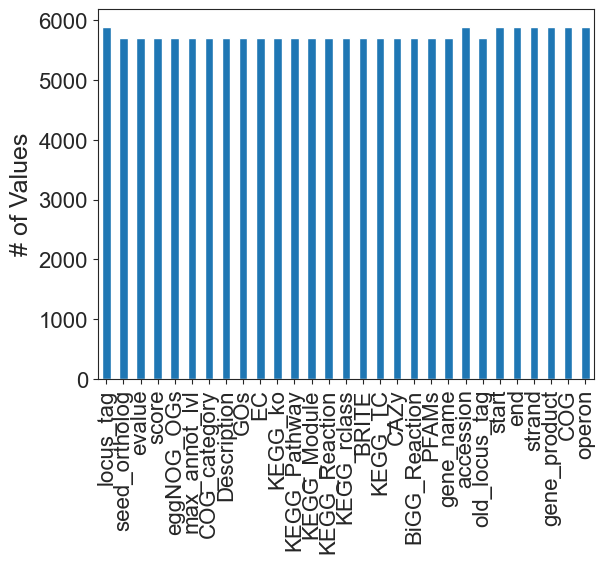

In [36]:
fig,ax = plt.subplots()
data.count().plot(kind='bar',ax=ax)
ax.set_ylabel('# of Values',fontsize=18)
ax.tick_params(labelsize=16)

## Fill missing values

Some organisms are missing gene names, so these will be filled with locus tag gene names.

In [37]:
# Fill in missing gene names with locus tag names
DF_annot['tmp_name'] = DF_annot.copy().index.tolist()
DF_annot.gene_name.fillna(DF_annot.tmp_name,inplace=True)
DF_annot.drop('tmp_name',axis=1,inplace=True)

 COG letters will also be converted to the full name.

In [29]:
# Fill missing COGs with X
DF_annot['COG'].fillna('X',inplace=True)

# Change single letter COG annotation to full description
DF_annot['COG'] = DF_annot.COG.apply(cog2str)

counts = DF_annot.COG.value_counts()
plt.pie(counts.values,labels=counts.index);

KeyError: '-'

Uncomment the following line to save the gene annotation dataset

In [31]:
DF_annot.to_csv(os.path.join('../..','data','processed','modulome','gene_info.csv'))

## GO Annotations

To start, download the GO Annotations for your organism from AmiGO 2

1. Go to [AmiGO 2](http://amigo.geneontology.org/amigo/search/annotation)
1. Filter for your organism
1. Click ``CustomDL``
1. Drag ``GO class (direct)`` to the end of your Selected Fields
1. Enter the location of your GO annotation file below and run the following code block

In [62]:
go_file = os.path.join('../..','data','external','modulome','GO_terms.csv')

In [64]:
DF_GO = pd.read_csv(go_file,header=0)
DF_GO.head()

,locus_tag,GOs
0,XNR_RS30570,NaN
1,XNR_RS00010,NaN
2,XNR_RS00015,NaN
3,XNR_RS00020,NaN
4,XNR_RS00025,NaN


Now we remove null entries

In [66]:
DF_GO = DF_GO[DF_GO.GOs.notnull()]

In [67]:
DF_GO.head()

,locus_tag,GOs
54,XNR_RS00270,mannosyltransferase activity
55,XNR_RS00270,molecular_function
56,XNR_RS00270,catalytic activity
57,XNR_RS00270,dolichyl-phosphate beta-D-mannosyltransferase ...
58,XNR_RS00270,cellular_component


Uncomment the line below to save the annotations

In [69]:
DF_GO.to_csv(os.path.join('../..','data','external','modulome','GO_annotations_curated.csv'))

# Change COG letters o full names

In [43]:
# Read gene_info4.csv
gene_info_file = os.path.join('../..','data','processed','modulome','gene_info5.csv')
DF_gene_info = pd.read_csv(gene_info_file,index_col=0)

#Read COG_dict.tsv
cog_dict_file = os.path.join('../..','data','external','modulome','COG_dict.tsv')
DF_cog_dict = pd.read_csv(cog_dict_file,sep='\t')

In [45]:
# create a dictionary from the COG dataframe
cog_dict = dict(zip(DF_cog_dict.Letter, DF_cog_dict['description']))

# replace the values in the COG column with the corresponding values from the dictionary
DF_gene_info['COG'] = DF_gene_info['COG'].replace(cog_dict)

In [47]:
DF_gene_info.to_csv(os.path.join('../..','data','processed','modulome','gene_info5.csv'))